<a href="https://colab.research.google.com/github/vaipos/ML-Specialization/blob/master/GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 matplotlib==3.5.1 tensorflow-datasets==4.5.2 ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 56.4 MB/s eta 0:00:00
  Attempting uninstall: keras
 

restart session

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

#Dependencies and dataset

In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist', split = 'train') # specifying that we only want the train partition, pipeline

# Data Viz with Matplot

In [ ]:
import numpy as np

iter = ds.as_numpy_iterator()

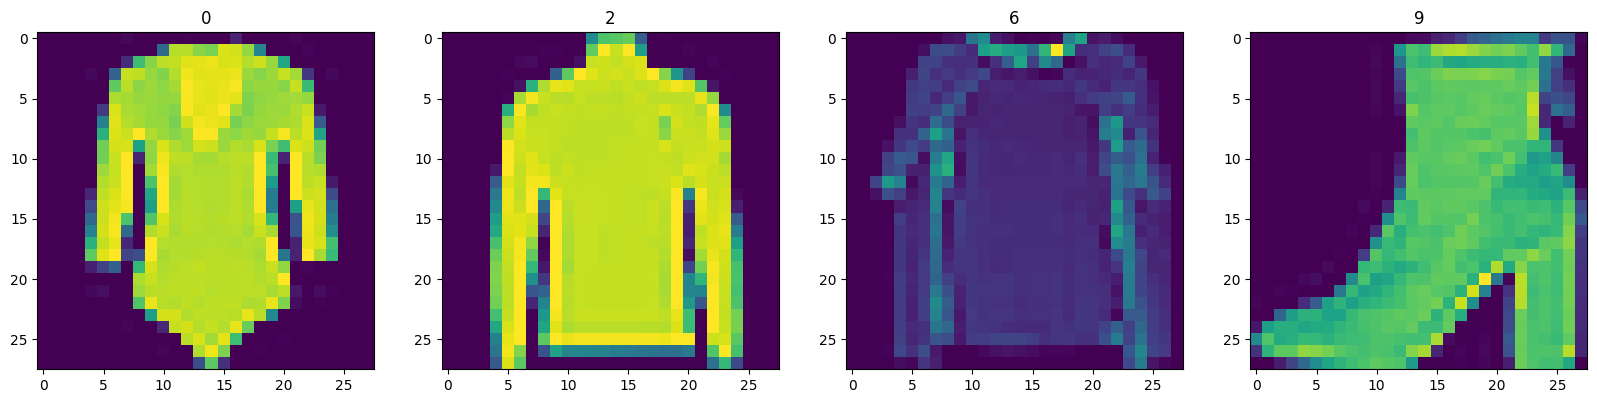

In [ ]:
fig, axis = plt.subplots(ncols=4, figsize=(20,20))

for x in range(len(axis)):
  sample = iter.next()
  axis[x].imshow(np.squeeze(sample['image']))
  axis[x].title.set_text(sample['label'])

In [ ]:
def scale_images(data):
  image = data['image']
  return image/255 # basically no more color

In [ ]:
ds = tfds.load('fashion_mnist', split= 'train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

#Build Neural Net:
* Discriminator
* Generator

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, LeakyReLU, Reshape, Dropout, UpSampling2D, Flatten

In [ ]:
def generator_arch():
  model = Sequential()
  model.add(Dense(7*7*128, input_dim= 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding ="same"))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding ="same"))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128,4,padding ="same"))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(128,4,padding ="same"))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1,4, padding="same", activation= "sigmoid"))

  return model

In [ ]:
generator = generator_arch()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

In [ ]:
def discriminator_arch():
  model = Sequential();
  model.add(Conv2D(32,5, input_shape= (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D( 64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Flatten()) # one dimensional
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # 1 is False image, 0 is True image

  return model;

In [ ]:
discriminator = discriminator_arch()
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_13 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)      